# 05 — Rep Counting Baseline

Rule-based push-up counting using the elbow-angle state machine. Evaluate on labeled videos with visual verification and threshold sensitivity analysis.

In [1]:
import sys
sys.path.insert(0, "..")

import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import pandas as pd
from pathlib import Path

from src.features.angles import compute_angle_sequence
from src.counting.state_machine import PushUpStateMachine, PushUpPhase

# Load manifest and YOLO keypoints
with open("../data/processed/keypoints/manifest.json") as f:
    manifest = json.load(f)

YOLO_DIR = Path("../data/processed/keypoints/yolo")
keypoints = {}
for vid_id in manifest:
    npy_path = YOLO_DIR / f"{vid_id}.npy"
    if npy_path.exists():
        keypoints[vid_id] = np.load(npy_path)

correct_ids = sorted([v for v, info in manifest.items() if info["label"] == "correct"])
incorrect_ids = sorted([v for v, info in manifest.items() if info["label"] == "incorrect"])

print(f"Loaded {len(keypoints)} videos")
print(f"  Correct: {len(correct_ids)}, Incorrect: {len(incorrect_ids)}")

Loaded 100 videos
  Correct: 50, Incorrect: 50


## Section 1: Run State Machine (Default Thresholds)

Run `PushUpStateMachine` on all videos with default 90 deg / 160 deg thresholds.

In [2]:
# Run state machine on all videos with default thresholds
results = {}
for vid_id, kps in keypoints.items():
    sm = PushUpStateMachine(down_threshold=90.0, up_threshold=160.0)
    angles = compute_angle_sequence(kps)
    phases = sm.label_sequence(kps)

    results[vid_id] = {
        "label": manifest[vid_id]["label"],
        "fps": manifest[vid_id]["fps"],
        "n_frames": len(kps),
        "rep_count": sm.count,
        "phases": phases,
        "elbow_angles": angles[:, 0],
        "angles": angles,
    }

rep_counts = [r["rep_count"] for r in results.values()]
print(f"Total videos processed: {len(results)}")
print(f"Rep count range: {min(rep_counts)} – {max(rep_counts)}")
print(f"Mean reps per video: {np.mean(rep_counts):.1f}")
print(f"Median reps: {np.median(rep_counts):.0f}")
print(f"Videos with 0 reps detected: {sum(1 for c in rep_counts if c == 0)}")

Total videos processed: 100
Rep count range: 0 – 2
Mean reps per video: 0.4
Median reps: 0
Videos with 0 reps detected: 58


## Section 2: Visual Verification

For 6 sample videos (3 correct, 3 incorrect), plot elbow angle over time with phase regions color-coded. This serves as qualitative ground truth.

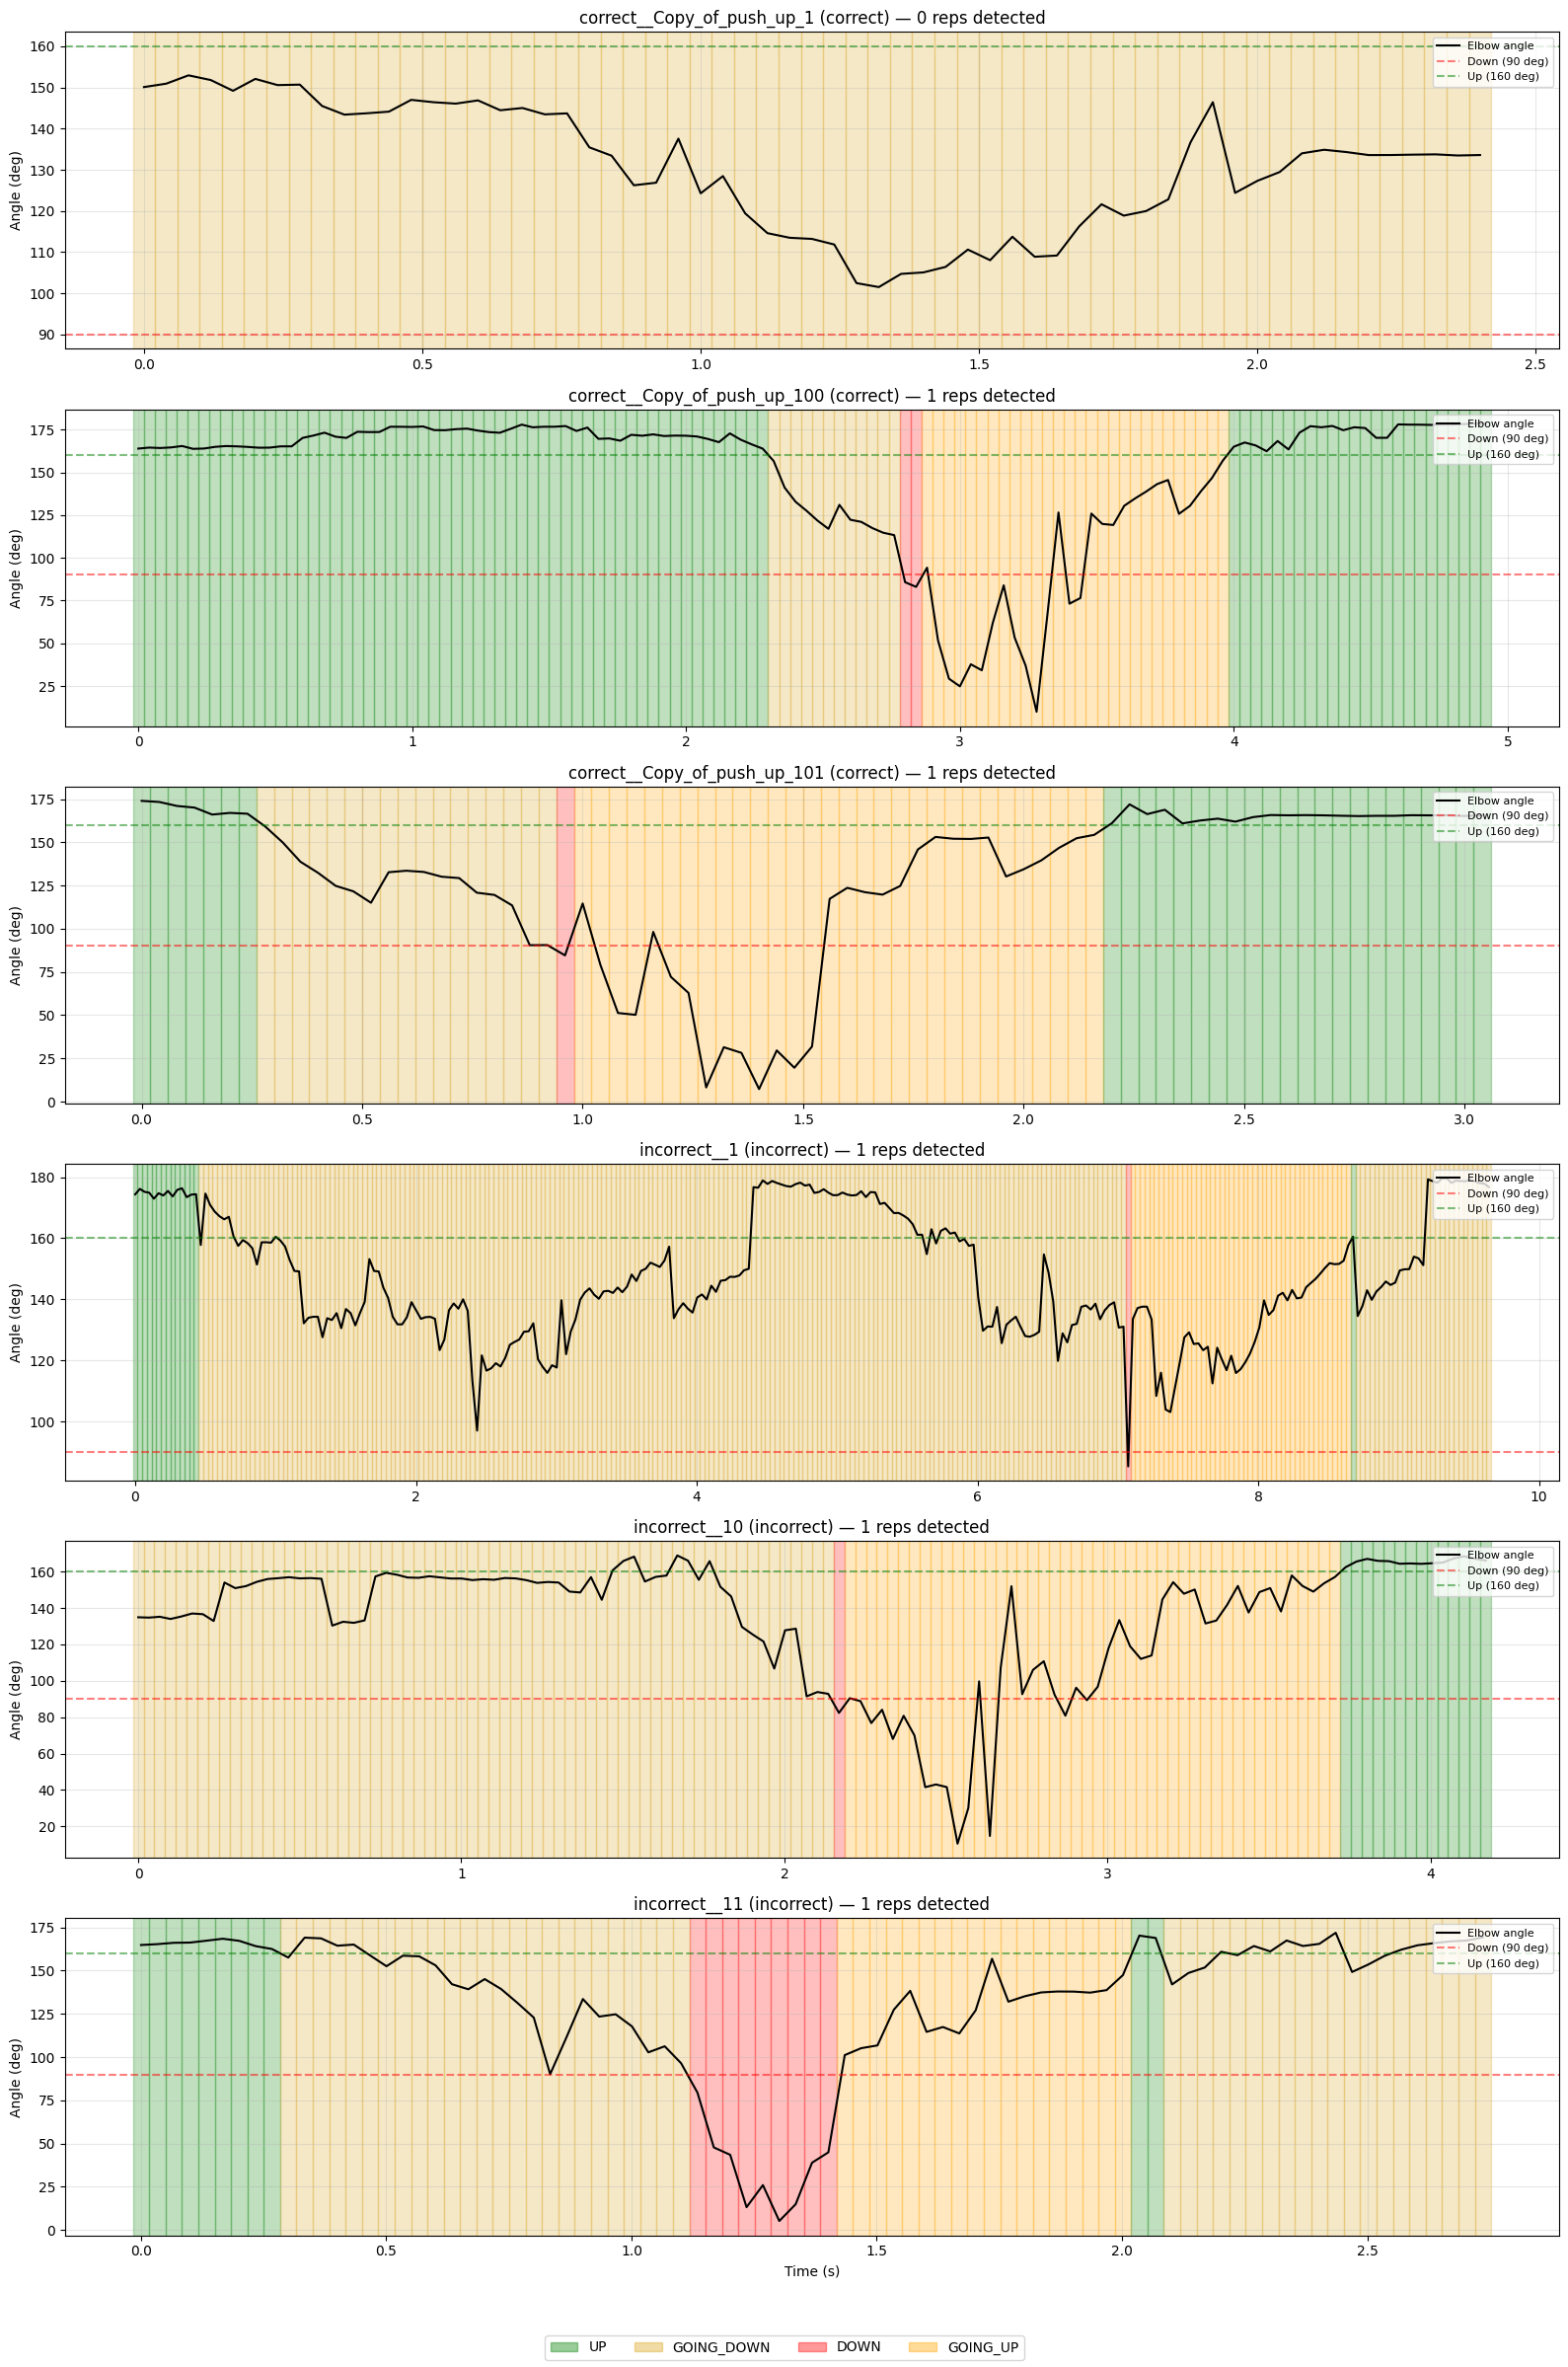

In [3]:
# Phase color mapping
PHASE_COLORS = {
    PushUpPhase.UP: "green",
    PushUpPhase.GOING_DOWN: "goldenrod",
    PushUpPhase.DOWN: "red",
    PushUpPhase.GOING_UP: "orange",
}

sample_correct = correct_ids[:3]
sample_incorrect = incorrect_ids[:3]
sample_ids = sample_correct + sample_incorrect

fig, axes = plt.subplots(len(sample_ids), 1, figsize=(16, 4 * len(sample_ids)))

for i, vid_id in enumerate(sample_ids):
    r = results[vid_id]
    fps = r["fps"]
    elbow = r["elbow_angles"]
    t = np.arange(len(elbow)) / fps
    phases = r["phases"]

    # Plot elbow angle
    axes[i].plot(t, elbow, "k-", linewidth=1.5, label="Elbow angle")

    # Color background by phase
    for j in range(len(phases)):
        axes[i].axvspan(
            t[j] - 0.5 / fps, t[j] + 0.5 / fps,
            color=PHASE_COLORS[phases[j]], alpha=0.25,
        )

    # Threshold lines
    axes[i].axhline(90, color="red", linestyle="--", alpha=0.5, label="Down (90 deg)")
    axes[i].axhline(160, color="green", linestyle="--", alpha=0.5, label="Up (160 deg)")

    axes[i].set_title(f"{vid_id} ({r['label']}) — {r['rep_count']} reps detected")
    axes[i].set_ylabel("Angle (deg)")
    axes[i].legend(loc="upper right", fontsize=8)
    axes[i].grid(True, alpha=0.3)

axes[-1].set_xlabel("Time (s)")

# Phase legend
patches = [mpatches.Patch(color=c, alpha=0.4, label=p.name) for p, c in PHASE_COLORS.items()]
fig.legend(handles=patches, loc="lower center", ncol=4, fontsize=10)
plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.savefig("../outputs/figures/05_phase_verification.png", dpi=120, bbox_inches="tight")
plt.show()

## Section 3: Threshold Sensitivity Analysis

Sweep down_threshold (70–110 deg) and up_threshold (140–175 deg). Heatmap shows how total rep counts change with threshold combinations.

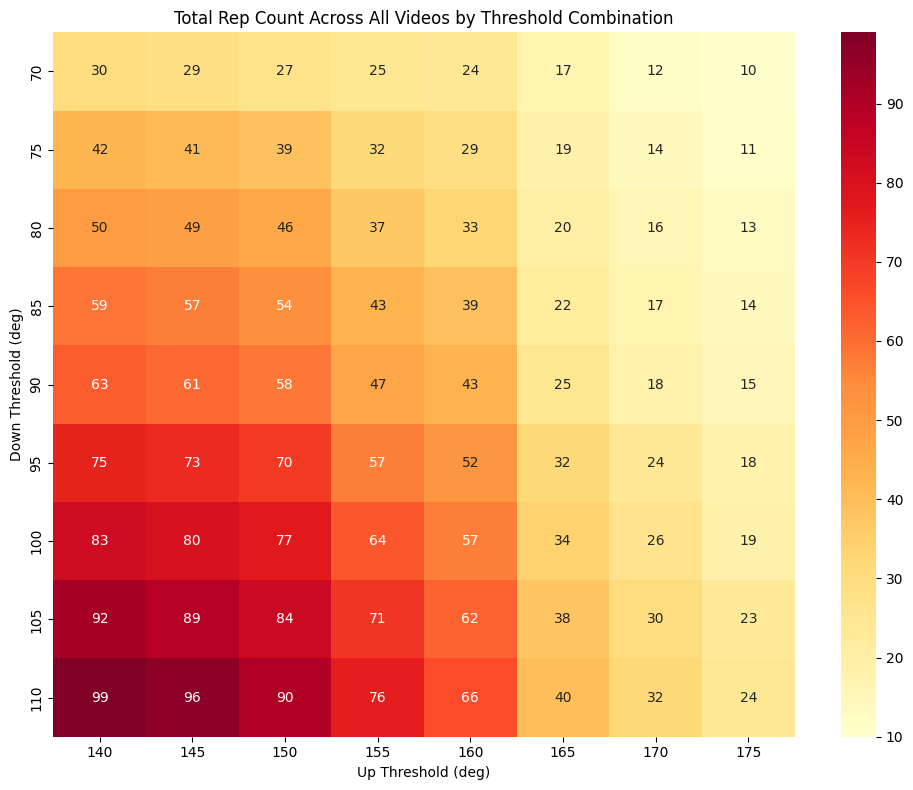


Stable threshold combinations (gradient below 9):
  Down=70 deg, Up=155 deg -> 25 reps
  Down=70 deg, Up=160 deg -> 24 reps
  Down=70 deg, Up=165 deg -> 17 reps
  Down=70 deg, Up=170 deg -> 12 reps
  Down=70 deg, Up=175 deg -> 10 reps
  Down=75 deg, Up=165 deg -> 19 reps
  Down=75 deg, Up=170 deg -> 14 reps
  Down=75 deg, Up=175 deg -> 11 reps
  Down=80 deg, Up=170 deg -> 16 reps
  Down=80 deg, Up=175 deg -> 13 reps
  Down=85 deg, Up=140 deg -> 59 reps
  Down=85 deg, Up=145 deg -> 57 reps
  Down=85 deg, Up=170 deg -> 17 reps
  Down=85 deg, Up=175 deg -> 14 reps
  Down=90 deg, Up=170 deg -> 18 reps
  Down=90 deg, Up=175 deg -> 15 reps
  Down=95 deg, Up=175 deg -> 18 reps
  Down=110 deg, Up=175 deg -> 24 reps


In [4]:
# Sweep thresholds
down_range = np.arange(70, 115, 5, dtype=float)
up_range = np.arange(140, 180, 5, dtype=float)
heatmap_data = np.zeros((len(down_range), len(up_range)))

for di, down_th in enumerate(down_range):
    for ui, up_th in enumerate(up_range):
        total_reps = 0
        for vid_id, kps in keypoints.items():
            sm = PushUpStateMachine(down_threshold=float(down_th), up_threshold=float(up_th))
            sm.label_sequence(kps)
            total_reps += sm.count
        heatmap_data[di, ui] = total_reps

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    heatmap_data, annot=True, fmt=".0f",
    xticklabels=[f"{x:.0f}" for x in up_range],
    yticklabels=[f"{y:.0f}" for y in down_range],
    cmap="YlOrRd", ax=ax,
)
ax.set_xlabel("Up Threshold (deg)")
ax.set_ylabel("Down Threshold (deg)")
ax.set_title("Total Rep Count Across All Videos by Threshold Combination")
plt.tight_layout()
plt.savefig("../outputs/figures/05_threshold_heatmap.png", dpi=120, bbox_inches="tight")
plt.show()

# Identify stable region (low gradient)
grad_y, grad_x = np.gradient(heatmap_data)
total_grad = np.abs(grad_y) + np.abs(grad_x)
threshold = np.percentile(total_grad, 25)
print(f"\nStable threshold combinations (gradient below {threshold:.0f}):")
for di in range(len(down_range)):
    for ui in range(len(up_range)):
        if total_grad[di, ui] <= threshold:
            print(f"  Down={down_range[di]:.0f} deg, Up={up_range[ui]:.0f} deg -> {heatmap_data[di, ui]:.0f} reps")

## Section 4: Per-Video Summary

Table of all videos with label, duration, frame count, detected reps, and elbow angle range. Flag videos with 0 reps.

Videos with 0 reps detected: 58
                      video_id     label  n_frames  elbow_min  elbow_max
    correct__Copy_of_push_up_1   correct        61 101.500000 152.899994
  correct__Copy_of_push_up_116   correct        75  93.400002 171.300003
  correct__Copy_of_push_up_127   correct        91  73.599998 172.800003
  correct__Copy_of_push_up_129   correct        84  79.699997 159.300003
  correct__Copy_of_push_up_131   correct        77  67.400002 166.100006
  correct__Copy_of_push_up_132   correct        79  70.199997 164.899994
  correct__Copy_of_push_up_133   correct        76  73.300003 158.399994
  correct__Copy_of_push_up_140   correct        87  71.699997 158.899994
  correct__Copy_of_push_up_142   correct        92  66.699997 158.000000
  correct__Copy_of_push_up_147   correct       123 106.300003 166.000000
  correct__Copy_of_push_up_148   correct       133  95.199997 165.000000
  correct__Copy_of_push_up_165   correct       100  68.300003 156.699997
  correct__Copy_of_

/var/folders/1q/pcrqby796fnbjgbr9ty_p12m0000gn/T/ipykernel_30159/683999586.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_summary, x="label", y="rep_count", ax=axes[0],
/var/folders/1q/pcrqby796fnbjgbr9ty_p12m0000gn/T/ipykernel_30159/683999586.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_summary, x="label", y="elbow_range", ax=axes[1],


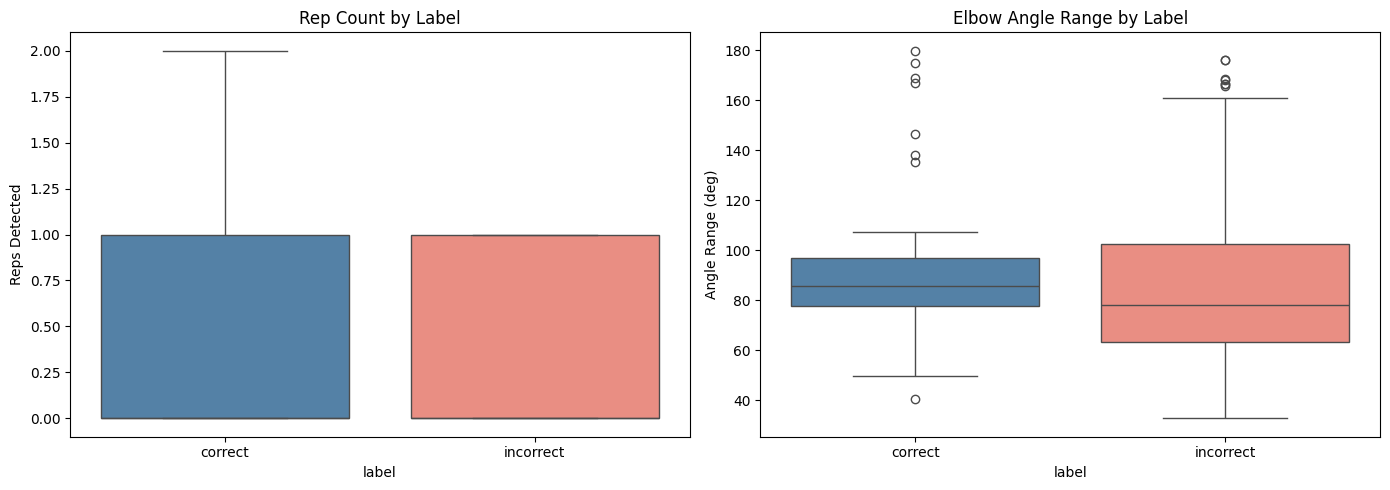

In [5]:
# Build summary table
summary_records = []
for vid_id, r in results.items():
    elbow = r["elbow_angles"]
    summary_records.append({
        "video_id": vid_id,
        "label": r["label"],
        "duration_s": manifest[vid_id]["duration_s"],
        "n_frames": r["n_frames"],
        "rep_count": r["rep_count"],
        "elbow_min": round(elbow.min(), 1),
        "elbow_max": round(elbow.max(), 1),
        "elbow_range": round(elbow.max() - elbow.min(), 1),
        "elbow_mean": round(elbow.mean(), 1),
    })

df_summary = pd.DataFrame(summary_records).sort_values("video_id").reset_index(drop=True)

# Flag videos with 0 reps
zero_rep = df_summary[df_summary["rep_count"] == 0]
print(f"Videos with 0 reps detected: {len(zero_rep)}")
if len(zero_rep) > 0:
    print(zero_rep[["video_id", "label", "n_frames", "elbow_min", "elbow_max"]].to_string(index=False))

# Compare correct vs incorrect
print("\nRep count statistics by label:")
print(df_summary.groupby("label")["rep_count"].describe().round(2).to_string())

# Box plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.boxplot(data=df_summary, x="label", y="rep_count", ax=axes[0],
            palette={"correct": "steelblue", "incorrect": "salmon"})
axes[0].set_title("Rep Count by Label")
axes[0].set_ylabel("Reps Detected")

sns.boxplot(data=df_summary, x="label", y="elbow_range", ax=axes[1],
            palette={"correct": "steelblue", "incorrect": "salmon"})
axes[1].set_title("Elbow Angle Range by Label")
axes[1].set_ylabel("Angle Range (deg)")

plt.tight_layout()
plt.savefig("../outputs/figures/05_rep_count_summary.png", dpi=120, bbox_inches="tight")
plt.show()

## Section 5: Phase Duration Analysis

Analyze time spent in each phase per rep. Incorrect form may show asymmetric phase durations compared to correct form.

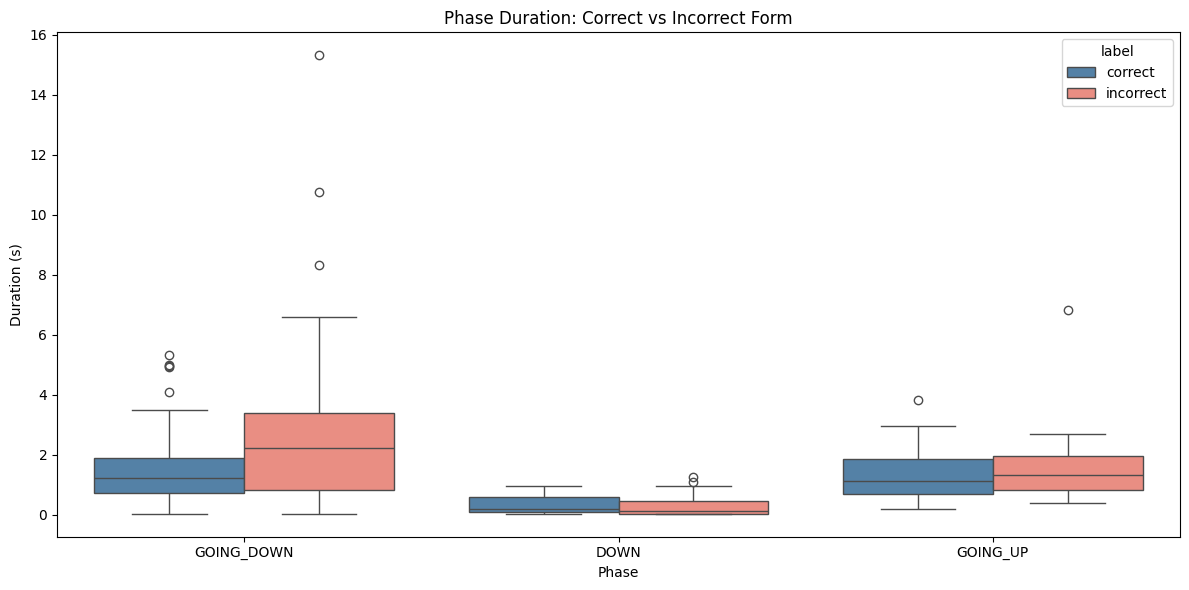

Phase duration statistics (seconds):
                      count   mean    std    min    25%    50%    75%     max
label     phase                                                              
correct   DOWN         34.0  0.351  0.310  0.040  0.080  0.180  0.590   0.960
          GOING_DOWN   68.0  1.519  1.183  0.040  0.710  1.240  1.890   5.320
          GOING_UP     34.0  1.305  0.838  0.200  0.680  1.140  1.870   3.840
incorrect DOWN         24.0  0.304  0.370  0.033  0.033  0.133  0.447   1.268
          GOING_DOWN   64.0  2.547  2.536  0.040  0.839  2.236  3.410  15.320
          GOING_UP     24.0  1.621  1.297  0.400  0.826  1.318  1.970   6.840


In [6]:
# Analyze phase durations
phase_records = []
for vid_id, r in results.items():
    fps = r["fps"]
    phases = r["phases"]
    if not phases:
        continue

    # Count consecutive frames in each phase
    current_phase = phases[0]
    run_length = 1

    for j in range(1, len(phases)):
        if phases[j] == current_phase:
            run_length += 1
        else:
            phase_records.append({
                "video_id": vid_id,
                "label": r["label"],
                "phase": current_phase.name,
                "duration_s": run_length / fps,
            })
            current_phase = phases[j]
            run_length = 1

    # Last run
    phase_records.append({
        "video_id": vid_id,
        "label": r["label"],
        "phase": current_phase.name,
        "duration_s": run_length / fps,
    })

df_phases = pd.DataFrame(phase_records)

# Focus on transitional phases (exclude long UP segments at start/end)
transition_phases = df_phases[df_phases["phase"].isin(["GOING_DOWN", "DOWN", "GOING_UP"])]

fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(
    data=transition_phases, x="phase", y="duration_s", hue="label",
    order=["GOING_DOWN", "DOWN", "GOING_UP"], ax=ax,
    palette={"correct": "steelblue", "incorrect": "salmon"},
)
ax.set_title("Phase Duration: Correct vs Incorrect Form")
ax.set_xlabel("Phase")
ax.set_ylabel("Duration (s)")
plt.tight_layout()
plt.savefig("../outputs/figures/05_phase_duration.png", dpi=120, bbox_inches="tight")
plt.show()

# Summary statistics
print("Phase duration statistics (seconds):")
print(
    transition_phases.groupby(["label", "phase"])["duration_s"]
    .describe()
    .round(3)
    .to_string()
)

## Save Results

In [7]:
# Save per-video rep counts and stats
RESULTS_DIR = Path("../outputs/results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

df_summary.to_csv(RESULTS_DIR / "rep_counting_baseline.csv", index=False)
print(f"Saved: {RESULTS_DIR / 'rep_counting_baseline.csv'} ({len(df_summary)} rows)")

df_summary.head(10)

Saved: ../outputs/results/rep_counting_baseline.csv (100 rows)


,video_id,label,duration_s,n_frames,rep_count,elbow_min,elbow_max,elbow_range,elbow_mean
0,correct__Copy_of_push_up_1,correct,2.44,61,0,101.500000,152.899994,51.400002,130.699997
1,correct__Copy_of_push_up_100,correct,4.96,124,1,9.900000,178.600006,168.699997,148.199997
2,correct__Copy_of_push_up_101,correct,3.08,77,1,7.300000,174.000000,166.699997,129.199997
3,correct__Copy_of_push_up_102,correct,3.32,83,1,0.000000,179.800003,179.800003,138.600006
4,correct__Copy_of_push_up_113,correct,3.08,77,1,2.300000,177.199997,174.899994,126.000000
5,correct__Copy_of_push_up_114,correct,3.52,88,2,44.299999,179.500000,135.199997,144.500000
6,correct__Copy_of_push_up_115,correct,5.48,137,1,41.700001,180.000000,138.199997,152.300003
7,correct__Copy_of_push_up_116,correct,3.00,75,0,93.400002,171.300003,77.900002,149.899994
8,correct__Copy_of_push_up_127,correct,3.64,91,0,73.599998,172.800003,99.199997,128.100006
9,correct__Copy_of_push_up_129,correct,3.36,84,0,79.699997,159.300003,79.599998,121.699997
